# 3 CO2 Emission in Countries <a id='2_Processing_and_Training_Data'></a>

## 3.1 Introduction<a id='2.1_Introduction'></a>

This step focuses on... 

## 3.2 Imports<a id='1.2_Imports'></a>

In [3]:
# Import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import os
import pickle
import datetime
from library.sb_utils import save_file
from sklearn import datasets,linear_model
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, PolynomialFeatures, normalize
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

pd.options.display.max_columns = 1000

In [4]:
AFRICA_ISOCODES = ['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD', 
               'COM', 'COG', 'COD', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'ETH', 'GAB', 
               'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MLI', 
               'MWI', 'MRT', 'MUS', 'MYT', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'REU', 
               'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'SWZ', 
               'TZA', 'TGO', 'TUN', 'UGA', 'ESH', 'ZMB', 'ZWE']
EUR_ISOCODES = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 
               'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 
               'SVN', 'ESP', 'SWE', 'GBR']


In [5]:
# Define my own functions
# RMSE Calcuation
def rmse(y_true, y_pre):
    return (np.mean((y_pre-y_true)**2))**0.5

# Normalization
def norm(x):
    MIN = x.min()
    MAX = x.max()
    x_norm = x.apply(lambda x: (x-MIN)/(MAX-MIN))
    return(x_norm)    

In [6]:
# Define global variables
hypertable = []

In [7]:
co2_data_df = pd.read_csv('../data/co2_data_updated.csv')
co2_data_df.head()

,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
0,AFG,Afghanistan,1/1/1949,0.015,NaN,7663783.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,5.873360e+13,4.500000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,AFG,Afghanistan,1/1/1950,0.084,NaN,7752000.0,1.949480e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.009350e+13,4.660000e+20,3.800000e+20,7.410000e+30,NaN,NaN,NaN,NaN,False,False
2,AFG,Afghanistan,1/1/1951,0.092,NaN,7840000.0,2.006385e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.146560e+13,4.820000e+20,4.030000e+20,8.080000e+30,NaN,NaN,NaN,NaN,False,False
3,AFG,Afghanistan,1/1/1952,0.092,NaN,7936000.0,2.074235e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.298010e+13,5.000000e+20,4.300000e+20,8.920000e+30,NaN,NaN,NaN,NaN,False,False
4,AFG,Afghanistan,1/1/1953,0.106,NaN,8040000.0,2.201546e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.464160e+13,5.200000e+20,4.850000e+20,1.070000e+31,NaN,NaN,NaN,NaN,False,False


In [8]:
def get_region_name(iso_code) : 
    if iso_code in AFRICA_ISOCODES:
        return 'Africa'
    if iso_code in EUR_ISOCODES:
        return 'Europe'
    if iso_code == 'USA':
        return 'USA'
    if iso_code == 'CHN':
        return 'China'
    if iso_code == 'IND':
        return 'India'
    if iso_code == 'RUS':
        return 'Russia'
    return 'Other'

In [9]:
co2_data_df['region_name'] = co2_data_df['iso_code'].apply(get_region_name)
co2_data_df['region_name'].unique()

array(['Other', 'Africa', 'Europe', 'China', 'India', 'Russia', 'USA'],
      dtype=object)

In [10]:
co2_data_df.columns

Index(['iso_code', 'country', 'year', 'annual_co2_prod_Megaton',
       'primary_energy_consumption_10Gwh', 'population', 'gdp', 'Unit_argi',
       'Value_agri_1000hectare', 'Unit_beef', 'Value_beef_tonnes',
       'energy_isnan', 'gdp_isnan', 'population_isnan', 'argi_isnan',
       'beef_isnan', 'primary_energy_consumption_square',
       'primary_energy_consumption_cubic', 'population_square',
       'population_cubic', 'gdp_square', 'gdp_cubic', 'Value_agri_square',
       'Value_agri_cubic', 'Value_beef_square', 'Value_beef_cubic',
       'emissions_gt_70k', 'emissions_gt_110k', 'region_name'],
      dtype='object')

In [11]:
co2_data_df = co2_data_df[['iso_code', 'region_name', 'country', 'year', 'annual_co2_prod_Megaton',
       'primary_energy_consumption_10Gwh', 'population', 'gdp', 'Unit_argi',
       'Value_agri_1000hectare', 'Unit_beef', 'Value_beef_tonnes',
       'energy_isnan', 'gdp_isnan', 'population_isnan', 'argi_isnan',
       'beef_isnan', 'primary_energy_consumption_square',
       'primary_energy_consumption_cubic', 'population_square',
       'population_cubic', 'gdp_square', 'gdp_cubic', 'Value_agri_square',
       'Value_agri_cubic', 'Value_beef_square', 'Value_beef_cubic',
       'emissions_gt_70k', 'emissions_gt_110k']]
co2_data_df.head()

,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
0,AFG,Other,Afghanistan,1/1/1949,0.015,NaN,7663783.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,5.873360e+13,4.500000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,AFG,Other,Afghanistan,1/1/1950,0.084,NaN,7752000.0,1.949480e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.009350e+13,4.660000e+20,3.800000e+20,7.410000e+30,NaN,NaN,NaN,NaN,False,False
2,AFG,Other,Afghanistan,1/1/1951,0.092,NaN,7840000.0,2.006385e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.146560e+13,4.820000e+20,4.030000e+20,8.080000e+30,NaN,NaN,NaN,NaN,False,False
3,AFG,Other,Afghanistan,1/1/1952,0.092,NaN,7936000.0,2.074235e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.298010e+13,5.000000e+20,4.300000e+20,8.920000e+30,NaN,NaN,NaN,NaN,False,False
4,AFG,Other,Afghanistan,1/1/1953,0.106,NaN,8040000.0,2.201546e+10,NaN,NaN,NaN,NaN,True,False,False,True,True,NaN,NaN,6.464160e+13,5.200000e+20,4.850000e+20,1.070000e+31,NaN,NaN,NaN,NaN,False,False


## 3.3 Modeling and Training

### 3.3.1 USA

In [12]:
co2_usa_df = co2_data_df[co2_data_df['country']=='United States']
co2_usa_df.tail()

,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
22069,USA,USA,United States,1/1/2015,5412.432,25739.632,320878016.0,1.690000e+13,NaN,NaN,NaN,NaN,False,False,False,True,True,662528655.5,1.705320e+13,1.030000e+17,3.300000e+25,2.860000e+26,4.830000e+39,NaN,NaN,NaN,NaN,False,False
22070,USA,USA,United States,1/1/2016,5292.268,25733.260,323016000.0,1.720000e+13,NaN,NaN,NaN,NaN,False,False,False,True,True,662200670.2,1.704060e+13,1.040000e+17,3.370000e+25,2.960000e+26,5.090000e+39,NaN,NaN,NaN,NaN,False,False
22071,USA,USA,United States,1/1/2017,5253.606,NaN,325084992.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,1.060000e+17,3.440000e+25,NaN,NaN,NaN,NaN,NaN,NaN,False,False
22072,USA,USA,United States,1/1/2018,5424.882,NaN,327096000.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,1.070000e+17,3.500000e+25,NaN,NaN,NaN,NaN,NaN,NaN,False,False
22073,USA,USA,United States,1/1/2019,5284.697,NaN,329064992.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,1.080000e+17,3.560000e+25,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [13]:
co2_usa_df.shape

(220, 29)

In [14]:
co2_usa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 21854 to 22073
Data columns (total 29 columns):
iso_code                             220 non-null object
region_name                          220 non-null object
country                              220 non-null object
year                                 220 non-null object
annual_co2_prod_Megaton              220 non-null float64
primary_energy_consumption_10Gwh     57 non-null float64
population                           220 non-null float64
gdp                                  197 non-null float64
Unit_argi                            0 non-null object
Value_agri_1000hectare               0 non-null float64
Unit_beef                            0 non-null object
Value_beef_tonnes                    0 non-null float64
energy_isnan                         220 non-null bool
gdp_isnan                            220 non-null bool
population_isnan                     220 non-null bool
argi_isnan                           220 no

In [15]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan',
                'emissions_gt_70k','emissions_gt_110k']
x_usa = co2_usa_df[feature_names].fillna(1)
y_usa = co2_usa_df['annual_co2_prod_Megaton']
print(x_usa,'\n\n\n',y_usa)
x_usa_train,x_usa_test,y_usa_train,y_usa_test = train_test_split(x_usa,y_usa,test_size=0.3,random_state=47)

       primary_energy_consumption_10Gwh           gdp   population  \
21854                             1.000  1.000000e+00    6801854.0   
21855                             1.000  1.000000e+00    6933517.0   
21856                             1.000  1.000000e+00    7067728.0   
21857                             1.000  1.000000e+00    7204538.0   
21858                             1.000  1.000000e+00    7343995.0   
...                                 ...           ...          ...   
22069                         25739.632  1.690000e+13  320878016.0   
22070                         25733.260  1.720000e+13  323016000.0   
22071                             1.000  1.000000e+00  325084992.0   
22072                             1.000  1.000000e+00  327096000.0   
22073                             1.000  1.000000e+00  329064992.0   

       Value_agri_1000hectare  Value_beef_tonnes  energy_isnan  gdp_isnan  \
21854                     1.0                1.0          True       True   
21855

In [16]:
# train the model
ml_usa = LinearRegression()
ml_usa.fit(x_usa_train,y_usa_train)

# predict
y_usa_pred_train = ml_usa.predict(x_usa_train)
 # print(y_usa_pred_train)
y_usa_pred_test = ml_usa.predict(x_usa_test)
 # print(y_usa_pred_test)
    
# calculate r2
ml_usa_r2_train = r2_score(y_usa_train,y_usa_pred_train)
print(ml_usa_r2_train)
ml_usa_r2_test = r2_score(y_usa_test,y_usa_pred_test)
print(ml_usa_r2_test)

0.9876029510054386
0.9892550260887227


In [17]:
# add results to hypertable
results = {}
results['Country/Region'] = 'USA'
results['r2_train'] = ml_usa_r2_train
results['rmse_train'] = rmse(y_usa_train,y_usa_pred_train)
results['r2_test'] = ml_usa_r2_test
results['rmse_test'] = rmse(y_usa_test,y_usa_pred_test)
results['coef'] = ml_usa.coef_
results['incpt'] = ml_usa.intercept_                       
results['model'] = ml_usa.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Multivariate(fea=5)'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')

,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


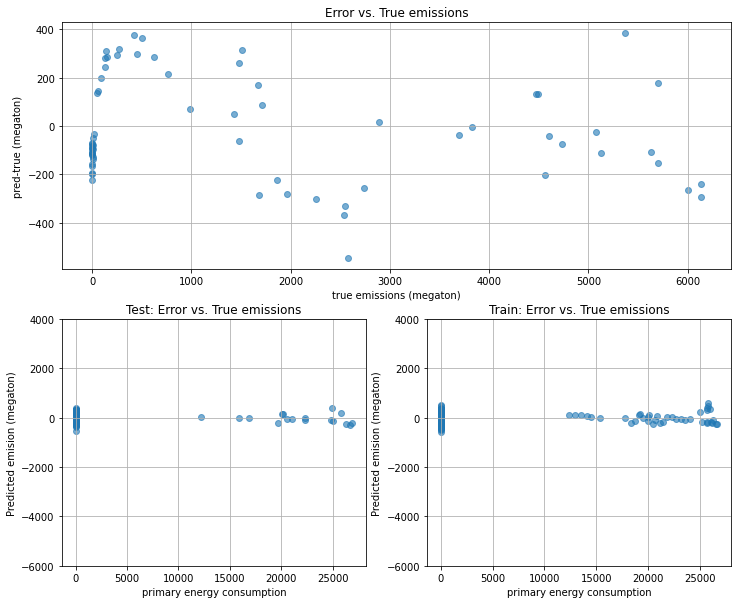

In [18]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_usa_test,y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_usa_test['primary_energy_consumption_10Gwh'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_usa_train['primary_energy_consumption_10Gwh'],y=y_usa_pred_train-y_usa_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

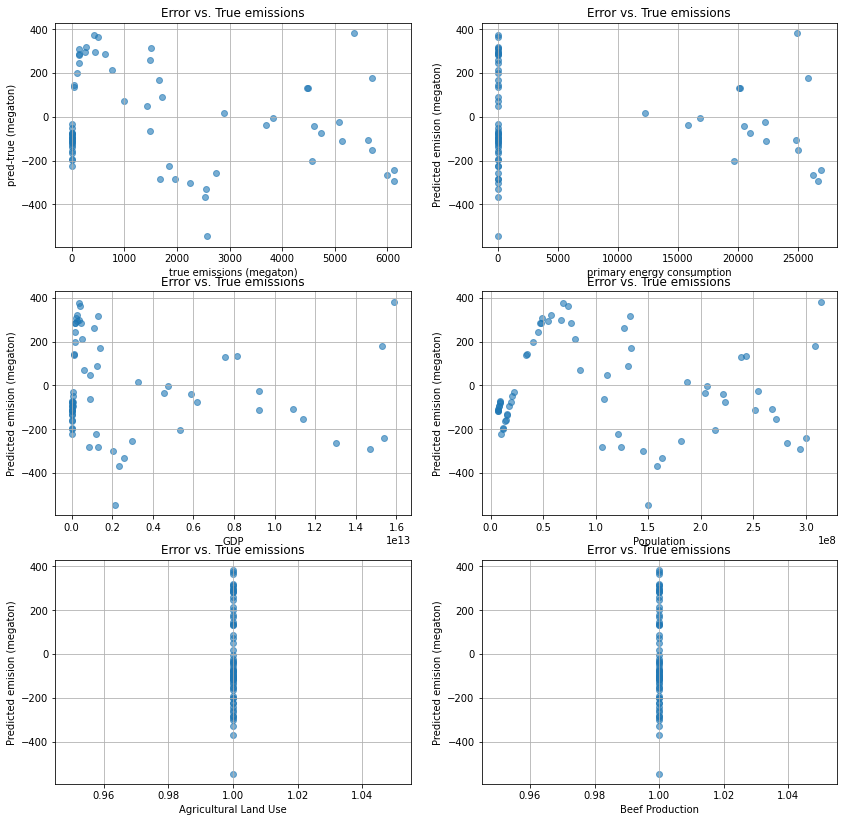

In [19]:
#plot the results
plt.figure(figsize=(14,14))

plt.subplot(321)
plt.scatter(x=y_usa_test,y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(322)
plt.scatter(x=x_usa_test['primary_energy_consumption_10Gwh'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(323)
plt.scatter(x=x_usa_test['gdp'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('GDP')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(324)
plt.scatter(x=x_usa_test['population'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('Population')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(325)
plt.scatter(x=x_usa_test['Value_agri_1000hectare'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('Agricultural Land Use')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(326)
plt.scatter(x=x_usa_test['Value_beef_tonnes'],y=y_usa_pred_test-y_usa_test,alpha=0.6)
plt.xlabel('Beef Production')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

### 3.3.2 China

In [20]:
co2_chn_df = co2_data_df[co2_data_df['country']=='China']
co2_chn_df.tail()

,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
4467,CHN,China,China,1/1/2015,9683.201,35001.978,1.406848e+09,1.640000e+13,1000 ha,528633.4,tonnes,6183515.0,False,False,False,False,False,1.225138e+09,4.288230e+13,1.980000e+18,2.780000e+27,2.690000e+26,4.410000e+39,2.794530e+11,1.480000e+17,3.823590e+13,2.360000e+20,False,False
4468,CHN,China,China,1/1/2016,9552.517,35437.843,1.414049e+09,1.690000e+13,1000 ha,528552.9,tonnes,6183349.0,False,False,False,False,False,1.255841e+09,4.450430e+13,2.000000e+18,2.830000e+27,2.860000e+26,4.830000e+39,2.793680e+11,1.480000e+17,3.823380e+13,2.360000e+20,False,False
4469,CHN,China,China,1/1/2017,9750.726,NaN,1.421022e+09,NaN,1000 ha,528531.1,tonnes,6360647.0,True,True,False,False,False,NaN,NaN,2.020000e+18,2.870000e+27,NaN,NaN,2.793450e+11,1.480000e+17,4.045780e+13,2.570000e+20,False,False
4470,CHN,China,China,1/1/2018,9956.569,NaN,1.427648e+09,NaN,1000 ha,528528.7,tonnes,6455137.0,True,True,False,False,False,NaN,NaN,2.040000e+18,2.910000e+27,NaN,NaN,2.793430e+11,1.480000e+17,4.166880e+13,2.690000e+20,False,False
4471,CHN,China,China,1/1/2019,10174.681,NaN,1.433784e+09,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,2.060000e+18,2.950000e+27,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [21]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan',
                'emissions_gt_70k','emissions_gt_110k']
x_chn = co2_chn_df[feature_names].fillna(1)
y_chn = co2_chn_df['annual_co2_prod_Megaton']
print(x_chn,'\n\n\n',y_chn)
x_chn_train,x_chn_test,y_chn_train,y_chn_test = train_test_split(x_chn,y_chn,test_size=0.3,random_state=47)

      primary_energy_consumption_10Gwh           gdp    population  \
4353                             1.000  1.000000e+00  3.986396e+08   
4354                             1.000  1.000000e+00  4.050612e+08   
4355                             1.000  1.000000e+00  4.072941e+08   
4356                             1.000  1.000000e+00  4.095628e+08   
4357                             1.000  1.000000e+00  4.118679e+08   
...                                ...           ...           ...   
4467                         35001.978  1.640000e+13  1.406848e+09   
4468                         35437.843  1.690000e+13  1.414049e+09   
4469                             1.000  1.000000e+00  1.421022e+09   
4470                             1.000  1.000000e+00  1.427648e+09   
4471                             1.000  1.000000e+00  1.433784e+09   

      Value_agri_1000hectare  Value_beef_tonnes  energy_isnan  gdp_isnan  \
4353                     1.0                1.0          True       True   
4354   

In [22]:
# train the model
ml_chn = LinearRegression()
ml_chn.fit(x_chn_train,y_chn_train)


# predict
y_chn_pred_train = ml_chn.predict(x_chn_train)
 # print(y_usa_pred_train)
y_chn_pred_test = ml_chn.predict(x_chn_test)
 # print(y_usa_pred_test)
    
# calculate r2
ml_chn_r2_train = r2_score(y_chn_train,y_chn_pred_train)
print(ml_chn_r2_train)
ml_chn_r2_test = r2_score(y_chn_test,y_chn_pred_test)
print(ml_chn_r2_test)

0.965933929000297
0.8752320341006973


In [23]:
# add results to hypertable
results = {}
results['Country/Region'] = 'China'
results['r2_train'] = ml_chn_r2_train
results['rmse_train'] = rmse(y_chn_train,y_chn_pred_train)
results['r2_test'] = ml_chn_r2_test
results['rmse_test'] = rmse(y_chn_test,y_chn_pred_test)
results['coef'] = ml_chn.coef_
results['incpt'] = ml_chn.intercept_                       
results['model'] = ml_chn.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Multivariate(fea=5)'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')

,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


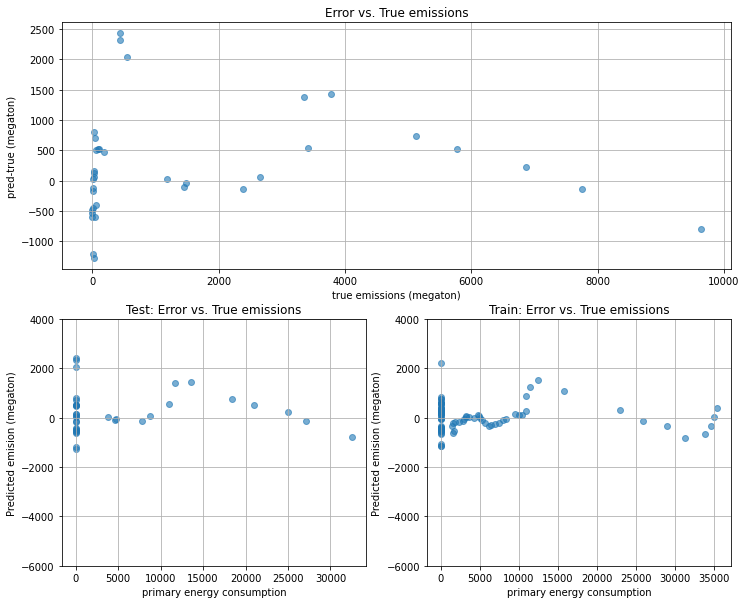

In [24]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_chn_test,y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_chn_test['primary_energy_consumption_10Gwh'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_chn_train['primary_energy_consumption_10Gwh'],y=y_chn_pred_train-y_chn_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')


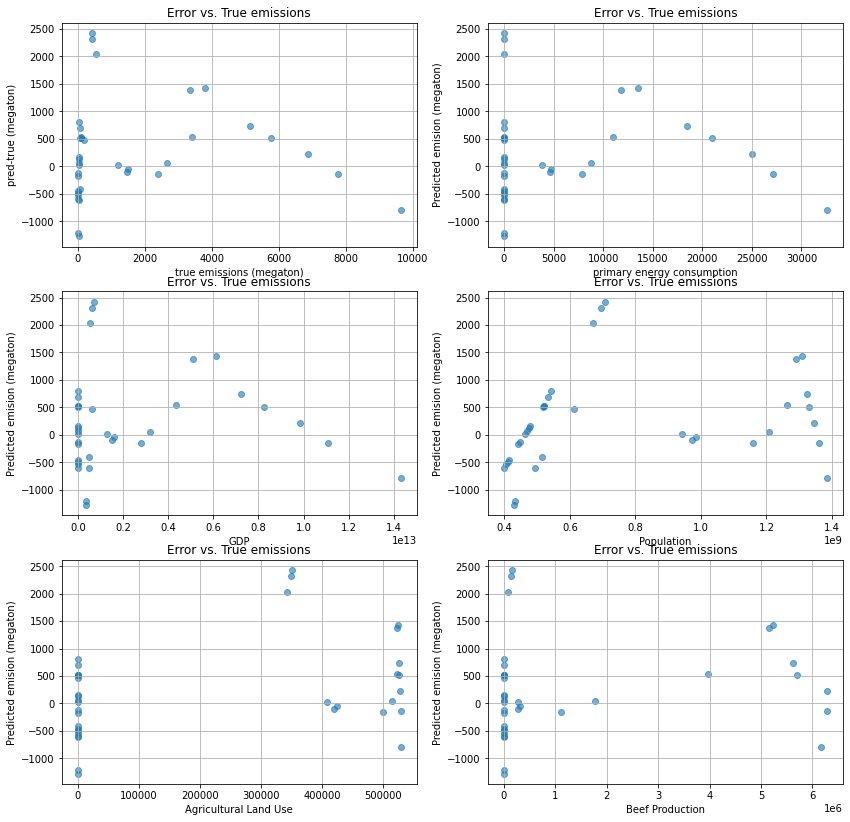

In [25]:
#plot the results
plt.figure(figsize=(14,14))

plt.subplot(321)
plt.scatter(x=y_chn_test,y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(322)
plt.scatter(x=x_chn_test['primary_energy_consumption_10Gwh'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(323)
plt.scatter(x=x_chn_test['gdp'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('GDP')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(324)
plt.scatter(x=x_chn_test['population'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('Population')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(325)
plt.scatter(x=x_chn_test['Value_agri_1000hectare'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('Agricultural Land Use')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(326)
plt.scatter(x=x_chn_test['Value_beef_tonnes'],y=y_chn_pred_test-y_chn_test,alpha=0.6)
plt.xlabel('Beef Production')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

### 3.3.3 Europe

In [26]:
co2_eur_df = co2_data_df[co2_data_df['iso_code'].isin(EUR_ISOCODES)]
co2_eur_df.tail()

,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
21849,GBR,Europe,United Kingdom,1/1/2015,422.491,2268.505,65860000.0,2.530000e+12,NaN,NaN,NaN,NaN,False,False,False,True,True,5146114.935,1.167399e+10,4.337540e+15,2.860000e+23,6.400000e+24,1.620000e+37,NaN,NaN,NaN,NaN,False,False
21850,GBR,Europe,United Kingdom,1/1/2016,399.110,2250.284,66298000.0,2.580000e+12,NaN,NaN,NaN,NaN,False,False,False,True,True,5063778.081,1.139494e+10,4.395420e+15,2.910000e+23,6.660000e+24,1.720000e+37,NaN,NaN,NaN,NaN,False,False
21851,GBR,Europe,United Kingdom,1/1/2017,388.088,NaN,66727000.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,4.452490e+15,2.970000e+23,NaN,NaN,NaN,NaN,NaN,NaN,False,False
21852,GBR,Europe,United Kingdom,1/1/2018,380.139,NaN,67142000.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,4.508050e+15,3.030000e+23,NaN,NaN,NaN,NaN,NaN,NaN,False,False
21853,GBR,Europe,United Kingdom,1/1/2019,369.878,NaN,67530000.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,4.560300e+15,3.080000e+23,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [27]:
co2_eur_df.shape

(4539, 29)

In [28]:
co2_eur_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 1481 to 21853
Data columns (total 29 columns):
iso_code                             4539 non-null object
region_name                          4539 non-null object
country                              4539 non-null object
year                                 4539 non-null object
annual_co2_prod_Megaton              4539 non-null float64
primary_energy_consumption_10Gwh     1346 non-null float64
population                           4481 non-null float64
gdp                                  3161 non-null float64
Unit_argi                            1269 non-null object
Value_agri_1000hectare               1269 non-null float64
Unit_beef                            1269 non-null object
Value_beef_tonnes                    1269 non-null float64
energy_isnan                         4539 non-null bool
gdp_isnan                            4539 non-null bool
population_isnan                     4539 non-null bool
argi_isnan         

In [29]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan',
                'emissions_gt_70k','emissions_gt_110k']
x_eur = co2_eur_df[feature_names].fillna(1)
y_eur = co2_eur_df['annual_co2_prod_Megaton']
print(x_eur,'\n\n\n',y_eur)
x_eur_train,x_eur_test,y_eur_train,y_eur_test = train_test_split(x_eur,y_eur,test_size=0.3,random_state=47)

       primary_energy_consumption_10Gwh           gdp  population  \
1481                              1.000  1.000000e+00   3261860.0   
1482                              1.000  1.000000e+00   3378831.0   
1483                              1.000  4.447080e+09   3391206.0   
1484                              1.000  1.000000e+00   3404003.0   
1485                              1.000  1.000000e+00   3417266.0   
...                                 ...           ...         ...   
21849                          2268.505  2.530000e+12  65860000.0   
21850                          2250.284  2.580000e+12  66298000.0   
21851                             1.000  1.000000e+00  66727000.0   
21852                             1.000  1.000000e+00  67142000.0   
21853                             1.000  1.000000e+00  67530000.0   

       Value_agri_1000hectare  Value_beef_tonnes  energy_isnan  gdp_isnan  \
1481                      1.0                1.0          True       True   
1482             

In [30]:
# train the model
ml_eur = LinearRegression()
ml_eur.fit(x_eur_train,y_eur_train)

# predict
y_eur_pred_train = ml_eur.predict(x_eur_train)
 # print(y_usa_pred_train)
y_eur_pred_test = ml_eur.predict(x_eur_test)
 # print(y_usa_pred_test)
    
# calculate r2
ml_eur_r2_train = r2_score(y_eur_train,y_eur_pred_train)
print(ml_eur_r2_train)
ml_eur_r2_test = r2_score(y_eur_test,y_eur_pred_test)
print(ml_eur_r2_test)

0.8399884527378241
0.818084949745157


In [31]:
# add results to hypertable
results = {}
results['Country/Region'] = 'Europe'
results['r2_train'] = ml_eur_r2_train
results['rmse_train'] = rmse(y_eur_train,y_eur_pred_train)
results['r2_test'] = ml_eur_r2_test
results['rmse_test'] = rmse(y_eur_test,y_eur_pred_test)
results['coef'] = ml_eur.coef_
results['incpt'] = ml_eur.intercept_                       
results['model'] = ml_eur.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Multivariate(fea=5)'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')



,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
2,Europe,0.839988,64.874311,0.818085,66.570810,"[0.14595503831954054, -3.8284013587791104e-11,...",-1.482994,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


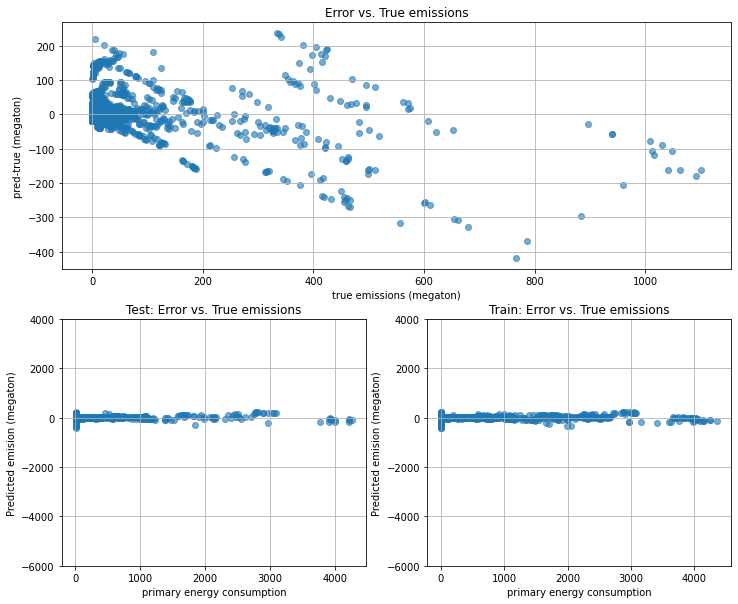

In [32]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_eur_test,y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_eur_test['primary_energy_consumption_10Gwh'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_eur_train['primary_energy_consumption_10Gwh'],y=y_eur_pred_train-y_eur_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')



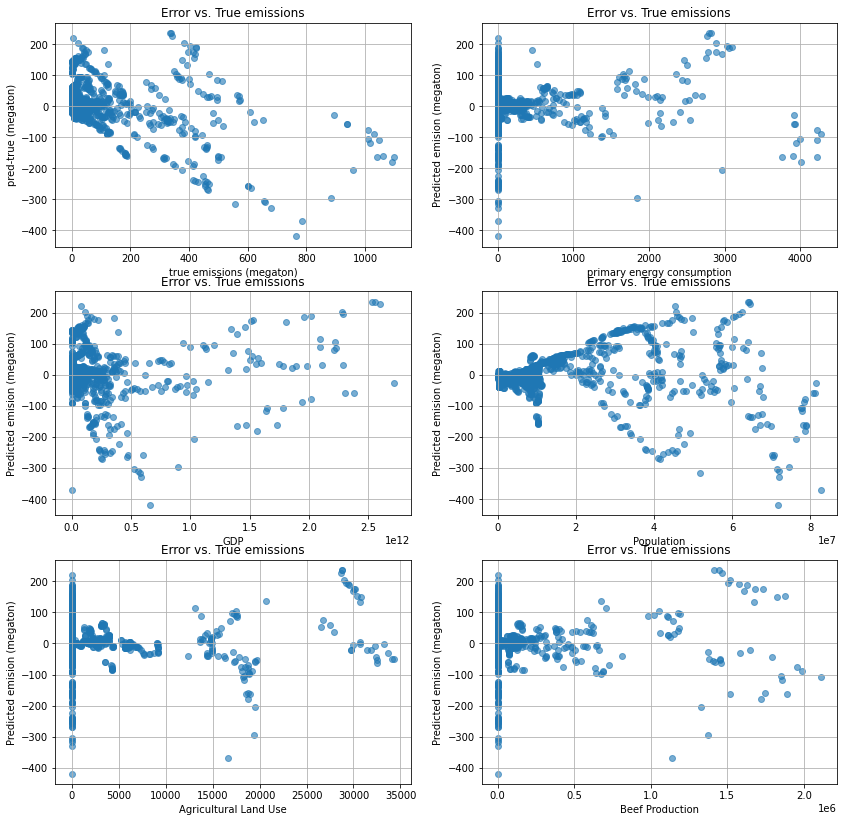

In [33]:
#plot the results
plt.figure(figsize=(14,14))

plt.subplot(321)
plt.scatter(x=y_eur_test,y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(322)
plt.scatter(x=x_eur_test['primary_energy_consumption_10Gwh'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(323)
plt.scatter(x=x_eur_test['gdp'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('GDP')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(324)
plt.scatter(x=x_eur_test['population'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('Population')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(325)
plt.scatter(x=x_eur_test['Value_agri_1000hectare'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('Agricultural Land Use')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(326)
plt.scatter(x=x_eur_test['Value_beef_tonnes'],y=y_eur_pred_test-y_eur_test,alpha=0.6)
plt.xlabel('Beef Production')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')


### 3.3.4 Africa

In [34]:
co2_afr_df = co2_data_df[co2_data_df['iso_code'].isin(AFRICA_ISOCODES)]
co2_afr_df.tail()

,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
23166,ZWE,Africa,Zimbabwe,1/1/2015,12.170,NaN,13815000.0,2.503057e+10,1000 ha,16200.0,tonnes,114297.0,True,False,False,False,False,NaN,NaN,1.908540e+14,2.640000e+21,6.270000e+20,1.570000e+31,262440000.0,4.251530e+12,1.306380e+10,1.493150e+15,False,False
23167,ZWE,Africa,Zimbabwe,1/1/2016,10.815,NaN,14030000.0,2.515176e+10,1000 ha,16200.0,tonnes,111470.0,True,False,False,False,False,NaN,NaN,1.968410e+14,2.760000e+21,6.330000e+20,1.590000e+31,262440000.0,4.251530e+12,1.242556e+10,1.385080e+15,False,False
23168,ZWE,Africa,Zimbabwe,1/1/2017,10.247,NaN,14237000.0,NaN,1000 ha,16200.0,tonnes,107633.0,True,True,False,False,False,NaN,NaN,2.026920e+14,2.890000e+21,NaN,NaN,262440000.0,4.251530e+12,1.158486e+10,1.246910e+15,False,False
23169,ZWE,Africa,Zimbabwe,1/1/2018,11.341,NaN,14439000.0,NaN,1000 ha,16200.0,tonnes,111133.0,True,True,False,False,False,NaN,NaN,2.084850e+14,3.010000e+21,NaN,NaN,262440000.0,4.251530e+12,1.235054e+10,1.372550e+15,False,False
23170,ZWE,Africa,Zimbabwe,1/1/2019,10.374,NaN,14645000.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,2.144760e+14,3.140000e+21,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [35]:
co2_afr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 294 to 23170
Data columns (total 29 columns):
iso_code                             3781 non-null object
region_name                          3781 non-null object
country                              3781 non-null object
year                                 3781 non-null object
annual_co2_prod_Megaton              3781 non-null float64
primary_energy_consumption_10Gwh     1194 non-null float64
population                           3781 non-null float64
gdp                                  3085 non-null float64
Unit_argi                            2711 non-null object
Value_agri_1000hectare               2711 non-null float64
Unit_beef                            2710 non-null object
Value_beef_tonnes                    2710 non-null float64
energy_isnan                         3781 non-null bool
gdp_isnan                            3781 non-null bool
population_isnan                     3781 non-null bool
argi_isnan          

In [36]:
co2_afr_df.shape

(3781, 29)

In [37]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan',
                'emissions_gt_70k','emissions_gt_110k']
x_afr = co2_afr_df[feature_names].fillna(1)
y_afr = co2_afr_df['annual_co2_prod_Megaton']
print(x_afr,'\n\n\n',y_afr)
x_afr_train,x_afr_test,y_afr_train,y_afr_test = train_test_split(x_afr,y_afr,test_size=0.3,random_state=47)


       primary_energy_consumption_10Gwh           gdp  population  \
294                                 1.0  1.000000e+00   5765808.0   
295                                 1.0  1.000000e+00   5839635.0   
296                                 1.0  1.000000e+00   5913223.0   
297                                 1.0  1.000000e+00   5988038.0   
298                                 1.0  1.000000e+00   6063800.0   
...                                 ...           ...         ...   
23166                               1.0  2.503057e+10  13815000.0   
23167                               1.0  2.515176e+10  14030000.0   
23168                               1.0  1.000000e+00  14237000.0   
23169                               1.0  1.000000e+00  14439000.0   
23170                               1.0  1.000000e+00  14645000.0   

       Value_agri_1000hectare  Value_beef_tonnes  energy_isnan  gdp_isnan  \
294                       1.0                1.0          True       True   
295              

In [38]:
# train the model
ml_afr = LinearRegression()
ml_afr.fit(x_afr_train,y_afr_train)

# predict
y_afr_pred_train = ml_afr.predict(x_afr_train)
 # print(y_afr_pred_train)
y_afr_pred_test = ml_afr.predict(x_afr_test)
 # print(y_afr_pred_test)
    
# calculate r2
ml_afr_r2_train = r2_score(y_afr_train,y_afr_pred_train)
print(ml_afr_r2_train)
ml_afr_r2_test = r2_score(y_afr_test,y_afr_pred_test)
print(ml_afr_r2_test)


0.7940529526050217
0.580662331912726


In [39]:
# add results to hypertable
results = {}
results['Country/Region'] = 'Africa'
results['r2_train'] = ml_afr_r2_train
results['rmse_train'] = rmse(y_afr_train,y_afr_pred_train)
results['r2_test'] = ml_afr_r2_test
results['rmse_test'] = rmse(y_afr_test,y_afr_pred_test)
results['coef'] = ml_afr.coef_
results['incpt'] = ml_afr.intercept_                       
results['model'] = ml_afr.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Multivariate(fea=5)'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')


,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
3,Africa,0.794053,21.003896,0.580662,30.291292,"[0.1732299836507017, 3.568727125978023e-11, -9...",-4.601639,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
2,Europe,0.839988,64.874311,0.818085,66.570810,"[0.14595503831954054, -3.8284013587791104e-11,...",-1.482994,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


In [40]:
coefs_afr = pd.DataFrame(hypertable)['coef'][3]
coefs_afr

array([ 1.73229984e-01,  3.56872713e-11, -9.90418141e-07, -5.45059990e-05,
        2.08707250e-04,  4.60395960e+00,  7.85640548e+00, -4.97379915e-14,
       -2.13032924e+01,  2.94796204e+01,  0.00000000e+00,  0.00000000e+00])

In [41]:
print(feature_names)

['primary_energy_consumption_10Gwh', 'gdp', 'population', 'Value_agri_1000hectare', 'Value_beef_tonnes', 'energy_isnan', 'gdp_isnan', 'population_isnan', 'argi_isnan', 'beef_isnan', 'emissions_gt_70k', 'emissions_gt_110k']


In [42]:
coefs_afr = dict(zip(list(feature_names), list(coefs_afr)))
coefs_afr


{'primary_energy_consumption_10Gwh': 0.1732299836507017,
 'gdp': 3.568727125978023e-11,
 'population': -9.904181411413214e-07,
 'Value_agri_1000hectare': -5.450599897662019e-05,
 'Value_beef_tonnes': 0.000208707249779913,
 'energy_isnan': 4.603959600099769,
 'gdp_isnan': 7.856405482726297,
 'population_isnan': -4.973799150320701e-14,
 'argi_isnan': -21.303292430097386,
 'beef_isnan': 29.47962037161572,
 'emissions_gt_70k': 0.0,
 'emissions_gt_110k': 0.0}

In [43]:
coefs_afr = pd.Series(coefs_afr)
coefs_afr

primary_energy_consumption_10Gwh    1.732300e-01
gdp                                 3.568727e-11
population                         -9.904181e-07
Value_agri_1000hectare             -5.450600e-05
Value_beef_tonnes                   2.087072e-04
energy_isnan                        4.603960e+00
gdp_isnan                           7.856405e+00
population_isnan                   -4.973799e-14
argi_isnan                         -2.130329e+01
beef_isnan                          2.947962e+01
emissions_gt_70k                    0.000000e+00
emissions_gt_110k                   0.000000e+00
dtype: float64

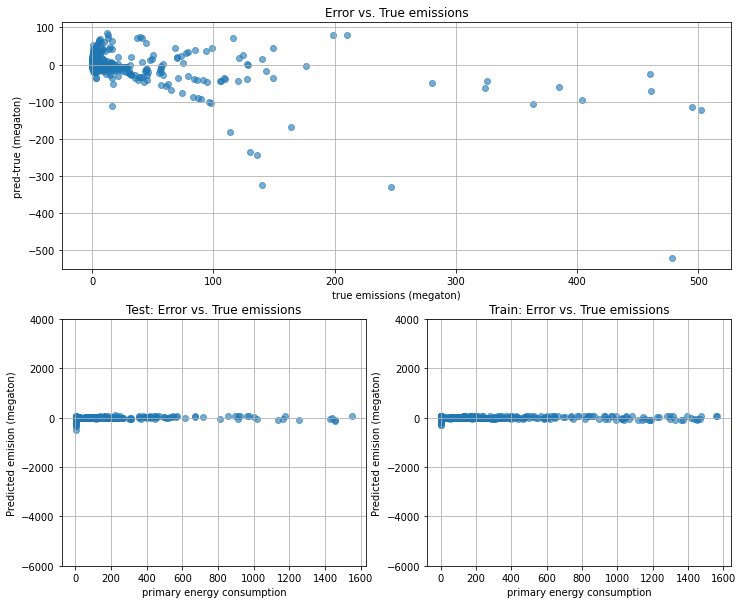

In [44]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_afr_test,y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_afr_test['primary_energy_consumption_10Gwh'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_afr_train['primary_energy_consumption_10Gwh'],y=y_afr_pred_train-y_afr_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')


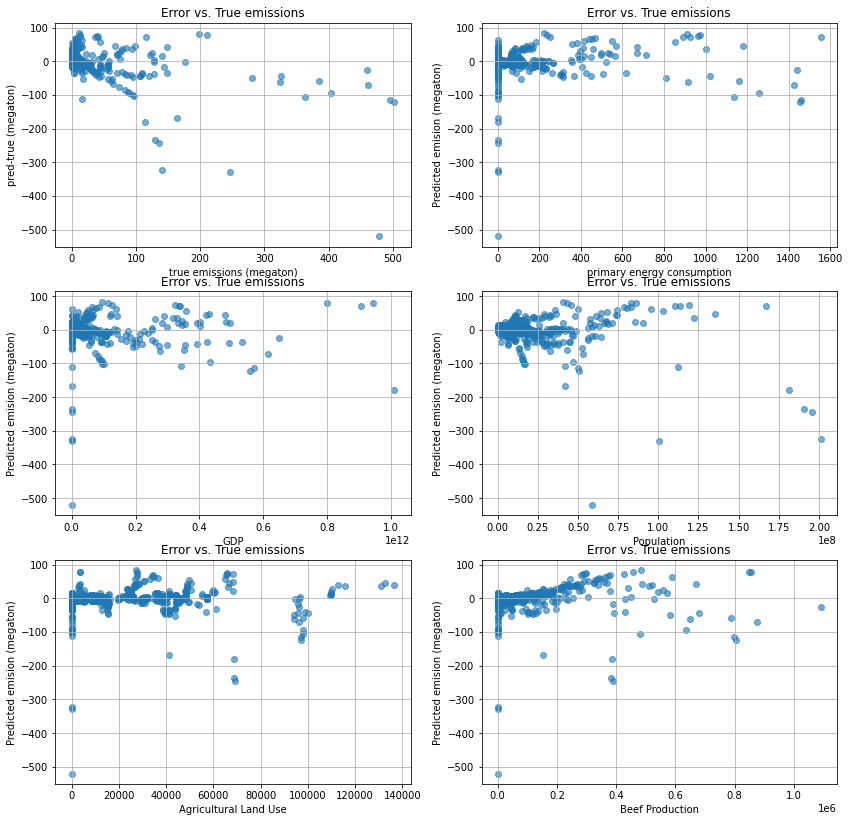

In [45]:
#plot the results
plt.figure(figsize=(14,14))

plt.subplot(321)
plt.scatter(x=y_afr_test,y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(322)
plt.scatter(x=x_afr_test['primary_energy_consumption_10Gwh'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(323)
plt.scatter(x=x_afr_test['gdp'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('GDP')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(324)
plt.scatter(x=x_afr_test['population'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('Population')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(325)
plt.scatter(x=x_afr_test['Value_agri_1000hectare'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('Agricultural Land Use')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(326)
plt.scatter(x=x_afr_test['Value_beef_tonnes'],y=y_afr_pred_test-y_afr_test,alpha=0.6)
plt.xlabel('Beef Production')
plt.ylabel('Predicted emision (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')


### 3.3.5 Dummy Vriables Approach

In [46]:
# choose 6 regions
co2_rgns_df = co2_data_df[co2_data_df['region_name'].isin(['USA','China','India','Russia','Europe','Africa'])].reset_index()
co2_rgns_df.head()

,index,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k
0,294,DZA,Africa,Algeria,1/1/1916,0.004,NaN,5765808.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.324450e+13,1.920000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,295,DZA,Africa,Algeria,1/1/1917,0.007,NaN,5839635.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.410130e+13,1.990000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,296,DZA,Africa,Algeria,1/1/1918,0.018,NaN,5913223.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.496620e+13,2.070000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,297,DZA,Africa,Algeria,1/1/1919,0.018,NaN,5988038.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.585660e+13,2.150000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,298,DZA,Africa,Algeria,1/1/1920,0.022,NaN,6063800.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.676970e+13,2.230000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [47]:
# use get.dummies on catagorical feature to generate numericla variables creat addtional columns
co2_rgns_df = co2_rgns_df.join(pd.get_dummies(co2_rgns_df['region_name'], prefix='dm', prefix_sep='_'))
co2_rgns_df.head()

,index,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
0,294,DZA,Africa,Algeria,1/1/1916,0.004,NaN,5765808.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.324450e+13,1.920000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
1,295,DZA,Africa,Algeria,1/1/1917,0.007,NaN,5839635.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.410130e+13,1.990000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
2,296,DZA,Africa,Algeria,1/1/1918,0.018,NaN,5913223.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.496620e+13,2.070000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
3,297,DZA,Africa,Algeria,1/1/1919,0.018,NaN,5988038.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.585660e+13,2.150000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
4,298,DZA,Africa,Algeria,1/1/1920,0.022,NaN,6063800.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.676970e+13,2.230000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0


In [48]:
co2_rgns_df.columns

Index(['index', 'iso_code', 'region_name', 'country', 'year',
       'annual_co2_prod_Megaton', 'primary_energy_consumption_10Gwh',
       'population', 'gdp', 'Unit_argi', 'Value_agri_1000hectare', 'Unit_beef',
       'Value_beef_tonnes', 'energy_isnan', 'gdp_isnan', 'population_isnan',
       'argi_isnan', 'beef_isnan', 'primary_energy_consumption_square',
       'primary_energy_consumption_cubic', 'population_square',
       'population_cubic', 'gdp_square', 'gdp_cubic', 'Value_agri_square',
       'Value_agri_cubic', 'Value_beef_square', 'Value_beef_cubic',
       'emissions_gt_70k', 'emissions_gt_110k', 'dm_Africa', 'dm_China',
       'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA'],
      dtype='object')

In [49]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan','emissions_gt_70k','emissions_gt_110k',
                'dm_Africa', 'dm_China', 'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA']
# feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
#                  'dm_Africa', 'dm_China', 'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA']
x_rgns = co2_rgns_df[feature_names].fillna(1)
y_rgns = co2_rgns_df['annual_co2_prod_Megaton']
#print(x_rgns,'\n\n\n',y_rgns)
x_rgns_train,x_rgns_test,y_rgns_train,y_rgns_test = train_test_split(x_rgns,y_rgns,test_size=0.3,random_state=47)
x_rgns.describe()

,primary_energy_consumption_10Gwh,gdp,population,Value_agri_1000hectare,Value_beef_tonnes,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
count,8978.000000,8.978000e+03,8.978000e+03,8978.000000,8.978000e+03,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000
mean,385.073333,2.230809e+11,3.630652e+07,11397.726744,1.002285e+05,0.421141,0.013255,0.505569,0.016819,0.018712,0.024504
std,2226.470934,1.049980e+12,1.295440e+08,42985.356654,3.966729e+05,0.493770,0.114370,0.499997,0.128600,0.135515,0.154617
min,0.208000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000e+00,2.812000e+06,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.084432e+10,7.089000e+06,1.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,35.226500,7.589775e+10,2.073655e+07,5293.250000,3.617525e+04,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,35437.843000,1.720000e+13,1.433784e+09,529038.600000,6.455137e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
# initiation
ml_rgns = LinearRegression() # ??? documentation put inception number into

In [51]:
#LinearRegression?

In [52]:
#LinearRegression??

In [53]:
# train the model

ml_rgns.fit(x_rgns_train,y_rgns_train)

# predict
y_rgns_pred_train = ml_rgns.predict(x_rgns_train)
 # print(y_afr_pred_train)
y_rgns_pred_test = ml_rgns.predict(x_rgns_test)
 # print(y_afr_pred_test)
    
# calculate r2
ml_rgns_r2_train = r2_score(y_rgns_train,y_rgns_pred_train)
print(ml_rgns_r2_train)
ml_rgns_r2_test = r2_score(y_rgns_test,y_rgns_pred_test)
print(ml_rgns_r2_test)


0.8546955154332705
0.8835954891683413


In [54]:
# add results to hypertable
results = {}
results['Country/Region'] = '6 Regions'
results['r2_train'] = ml_rgns_r2_train
results['rmse_train'] = rmse(y_rgns_train,y_rgns_pred_train)
results['r2_test'] = ml_rgns_r2_test
results['rmse_test'] = rmse(y_rgns_test,y_rgns_pred_test)
results['coef'] = ml_rgns.coef_
results['incpt'] = ml_rgns.intercept_                       
results['model'] = ml_rgns.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Dummies of USA, China, India, Russia, Europe, Africa'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')


,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
3,Africa,0.794053,21.003896,0.580662,30.291292,"[0.1732299836507017, 3.568727125978023e-11, -9...",-4.601639,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
2,Europe,0.839988,64.874311,0.818085,66.570810,"[0.14595503831954054, -3.8284013587791104e-11,...",-1.482994,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
4,6 Regions,0.854696,248.187434,0.883595,171.076869,"[0.12095114157735147, 1.0898233159802549e-10, ...",-257.285604,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Dummies of USA, China, India, Russia, Europe, ..."
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


In [55]:
pd.DataFrame(hypertable)['coef'][3].round(3)

array([  0.173,   0.   ,  -0.   ,  -0.   ,   0.   ,   4.604,   7.856,
        -0.   , -21.303,  29.48 ,   0.   ,   0.   ])

In [56]:
coefs_rgns = hypertable[4]['coef']
coefs_rgns = pd.Series(dict(zip(list(feature_names), list(coefs_rgns)))).sort_values()
coefs_rgns

dm_India                           -9.374396e+02
dm_China                           -6.188093e+02
argi_isnan                         -7.057264e+01
gdp_isnan                          -1.946574e+01
Value_agri_1000hectare             -1.397183e-03
emissions_gt_110k                  -3.410605e-13
emissions_gt_70k                    2.273737e-13
gdp                                 1.089823e-10
population                          2.448480e-06
Value_beef_tonnes                   1.628428e-04
primary_energy_consumption_10Gwh    1.209511e-01
population_isnan                    1.039711e+01
energy_isnan                        7.585604e+01
beef_isnan                          8.091032e+01
dm_Africa                           1.900142e+02
dm_Europe                           1.932382e+02
dm_Russia                           3.947461e+02
dm_USA                              7.782503e+02
dtype: float64

The results show that the coefficients for the features that we are interested the most in are small, including gdp, population, Value_agri_1000hectare, Value_beef_tonnes, and primary_energy_consumption_10Gwh. Therefore, there is a need to normalize the origin data.

In [57]:
#plot the results
# plt.figure(figsize=(12,10))

# plt.subplot(211)
# plt.scatter(x=y_rgns_test,y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('true emissions (megaton)')
# plt.ylabel('pred-true (megaton)')
# plt.title('Error vs. True emissions')
# plt.grid('on')

# plt.subplot(223)
# plt.scatter(x=x_rgns_test['primary_energy_consumption_10Gwh'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('primary energy consumption')
# plt.ylabel('Predicted emision (megaton)')
# plt.title('Test: Error vs. True emissions')
# plt.ylim([-6000,4000])
# plt.grid('on')

# plt.subplot(224)
# plt.scatter(x=x_rgns_train['primary_energy_consumption_10Gwh'],y=y_rgns_pred_train-y_rgns_train,alpha=0.6)
# plt.xlabel('primary energy consumption')
# plt.ylabel('Predicted emision (megaton)')
# plt.title('Train: Error vs. True emissions')
# plt.ylim([-6000,4000])
# plt.grid('on')


In [58]:
#plot the results

# plt.figure(figsize=(14,14))

# plt.subplot(321)
# plt.scatter(x=y_rgns_test,y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('true emissions (megaton)')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True emissions')
# plt.grid('on')

# plt.subplot(322)
# plt.scatter(x=x_rgns_test['primary_energy_consumption_10Gwh'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('primary energy consumption')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True primary energy consumption')
# plt.grid('on')

# plt.subplot(323)
# plt.scatter(x=x_rgns_test['gdp'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('GDP')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True GDP')
# plt.grid('on')

# plt.subplot(324)
# plt.scatter(x=x_rgns_test['population'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('Population')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True Population')
# plt.grid('on')

# plt.subplot(325)
# plt.scatter(x=x_rgns_test['Value_agri_1000hectare'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('Agricultural Land Use')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True Agricultural Land Use')
# plt.grid('on')

# plt.subplot(326)
# plt.scatter(x=x_rgns_test['Value_beef_tonnes'],y=y_rgns_pred_test-y_rgns_test,alpha=0.6)
# plt.xlabel('Beef Production')
# plt.ylabel('pred-true emission(megaton)')
# plt.title('Error vs. True Beef Production')
# plt.grid('on')

### 3.3.6 Data Scaling (Normalization)

In [59]:
co2_rgns_df.head()

,index,iso_code,region_name,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Unit_argi,Value_agri_1000hectare,Unit_beef,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,emissions_gt_70k,emissions_gt_110k,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
0,294,DZA,Africa,Algeria,1/1/1916,0.004,NaN,5765808.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.324450e+13,1.920000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
1,295,DZA,Africa,Algeria,1/1/1917,0.007,NaN,5839635.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.410130e+13,1.990000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
2,296,DZA,Africa,Algeria,1/1/1918,0.018,NaN,5913223.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.496620e+13,2.070000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
3,297,DZA,Africa,Algeria,1/1/1919,0.018,NaN,5988038.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.585660e+13,2.150000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0
4,298,DZA,Africa,Algeria,1/1/1920,0.022,NaN,6063800.0,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,NaN,NaN,3.676970e+13,2.230000e+20,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1,0,0,0,0,0


In [60]:
# co2_rgns_df.info()

In [61]:
# normalize?

In [62]:
# x_array = np.array([2,3,5,6,7,4,8,7,6])
# print(type(x_array))
# print(x_array)
# print(x_array.shape)
# normalized_arr = normalize([x_array])
# print(normalized_arr)

In [63]:
# a = pd.DataFrame([[1, 2,  3, 10],[1, 2,  3, 10],[1, 2,  3, 10],[2, 4,  6, 20]])
# print(type(np.array(a[:][1])))
# print(np.array(a[:][1]))
# print(np.array(a[:][1]).shape)
# print(normalize([a[:][1]]))
# print(normalize(np.array([a[:][1]])))
# print(normalize([np.array(a[:][1])]))
# print(normalize(np.array(a[:][1]).reshape(1, -1)))

In [64]:
# co2_rgns_df_norm = co2_rgns_df
# a = pd.DataFrame(normalize([co2_rgns_df['primary_energy_consumption_10Gwh'].fillna(1)],axis=1)[0])
# co2_rgns_df.describe()
# a.max()

In [65]:
co2_rgns_df.describe()

,index,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
count,8978.000000,8978.000000,2733.000000,8.920000e+03,6.714000e+03,4096.000000,4.095000e+03,2.733000e+03,2.733000e+03,8.920000e+03,8.920000e+03,6.714000e+03,6.714000e+03,4.096000e+03,4.096000e+03,4.095000e+03,4.095000e+03,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000
mean,11784.336155,134.422061,1262.694250,3.654259e+07,2.983051e+11,24981.423025,2.197427e+05,1.676978e+07,3.749614e+11,1.822012e+16,1.787018e+25,1.540807e+24,1.706926e+37,4.334347e+09,1.664638e+15,3.669637e+11,1.359236e+18,0.421141,0.013255,0.505569,0.016819,0.018712,0.024504
std,6320.903524,610.161585,3896.272144,1.299313e+08,1.204917e+12,60919.468210,5.645836e+05,9.616325e+07,2.664165e+12,1.415533e+17,1.743536e+26,1.508590e+25,2.220767e+38,2.746057e+10,1.368454e+16,2.595062e+12,1.508775e+19,0.493770,0.114370,0.499997,0.128600,0.135515,0.154617
min,294.000000,-0.081000,0.208000,4.500000e+04,6.378000e+07,1.500000,3.000000e+00,4.326400e-02,8.998912e-03,2.025000e+09,9.112500e+13,4.067890e+15,2.590000e+23,2.250000e+00,3.375000e+00,9.000000e+00,2.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6443.250000,0.658000,57.276000,2.891500e+06,7.172994e+09,2129.867500,1.014000e+04,3.280540e+03,1.878962e+05,8.360770e+12,2.417500e+19,5.142500e+19,3.692500e+29,4.536336e+06,9.661794e+09,1.028196e+08,1.042590e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11797.500000,5.068000,185.468000,7.169149e+06,2.798249e+10,8184.500000,4.510200e+04,3.439838e+04,6.379799e+06,5.139670e+13,3.685000e+20,7.835000e+20,2.190000e+31,6.698607e+07,5.482480e+11,2.034190e+09,9.174610e+13,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,17345.750000,42.720250,651.826000,2.095725e+07,1.307500e+11,27630.000000,1.598755e+05,4.248771e+05,2.769460e+08,4.392068e+14,9.202500e+21,1.712500e+22,2.237500e+33,7.634169e+08,2.109320e+13,2.556019e+10,4.086455e+15,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,23170.000000,10174.681000,35437.843000,1.433784e+09,1.720000e+13,529038.600000,6.455137e+06,1.255841e+09,4.450430e+13,2.060000e+18,2.950000e+27,2.960000e+26,5.090000e+39,2.798820e+11,1.480000e+17,4.166880e+13,2.690000e+20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
co2_rgns_df_norm = co2_rgns_df.copy(deep=True)

features = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes']

for name in features:
    co2_rgns_df_norm[name] = pd.DataFrame(normalize([co2_rgns_df[name].fillna(1)])[0])
    #co2_rgns_df_norm[name] = norm(co2_rgns_df[name].fillna(1))

co2_rgns_df_norm.describe()

,index,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,primary_energy_consumption_square,primary_energy_consumption_cubic,population_square,population_cubic,gdp_square,gdp_cubic,Value_agri_square,Value_agri_cubic,Value_beef_square,Value_beef_cubic,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
count,8978.000000,8978.000000,8.978000e+03,8.978000e+03,8.978000e+03,8.978000e+03,8.978000e+03,2.733000e+03,2.733000e+03,8.920000e+03,8.920000e+03,6.714000e+03,6.714000e+03,4.096000e+03,4.096000e+03,4.095000e+03,4.095000e+03,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000
mean,11784.336155,134.422061,1.798705e-03,2.848264e-03,2.193450e-03,2.705057e-03,2.585548e-03,1.676978e+07,3.749614e+11,1.822012e+16,1.787018e+25,1.540807e+24,1.706926e+37,4.334347e+09,1.664638e+15,3.669637e+11,1.359236e+18,0.421141,0.013255,0.505569,0.016819,0.018712,0.024504
std,6320.903524,610.161585,1.040000e-02,1.016279e-02,1.032395e-02,1.020184e-02,1.023279e-02,9.616325e+07,2.664165e+12,1.415533e+17,1.743536e+26,1.508590e+25,2.220767e+38,2.746057e+10,1.368454e+16,2.595062e+12,1.508775e+19,0.493770,0.114370,0.499997,0.128600,0.135515,0.154617
min,294.000000,-0.081000,9.715828e-07,7.845048e-11,9.832529e-15,2.373330e-07,2.579654e-08,4.326400e-02,8.998912e-03,2.025000e+09,9.112500e+13,4.067890e+15,2.590000e+23,2.250000e+00,3.375000e+00,9.000000e+00,2.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6443.250000,0.658000,4.671071e-06,2.206028e-04,9.832529e-15,2.373330e-07,2.579654e-08,3.280540e+03,1.878962e+05,8.360770e+12,2.417500e+19,5.142500e+19,3.692500e+29,4.536336e+06,9.661794e+09,1.028196e+08,1.042590e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11797.500000,5.068000,4.671071e-06,5.561355e-04,1.066271e-04,2.373330e-07,2.579654e-08,3.439838e+04,6.379799e+06,5.139670e+13,3.685000e+20,7.835000e+20,2.190000e+31,6.698607e+07,5.482480e+11,2.034190e+09,9.174610e+13,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,17345.750000,42.720250,1.645455e-04,1.626792e-03,7.462668e-04,1.256263e-03,9.331964e-04,4.248771e+05,2.769460e+08,4.392068e+14,9.202500e+21,1.712500e+22,2.237500e+33,7.634169e+08,2.109320e+13,2.556019e+10,4.086455e+15,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,23170.000000,10174.681000,1.655327e-01,1.124811e-01,1.691195e-01,1.255583e-01,1.665202e-01,1.255841e+09,4.450430e+13,2.060000e+18,2.950000e+27,2.960000e+26,5.090000e+39,2.798820e+11,1.480000e+17,4.166880e+13,2.690000e+20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
# build training dataset
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan','emissions_gt_70k','emissions_gt_110k',
                'dm_Africa', 'dm_China', 'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA']
# feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
#                  'dm_Africa', 'dm_China', 'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA']
x_rgns_norm = co2_rgns_df_norm[feature_names].fillna(1)
y_rgns_norm = co2_rgns_df_norm['annual_co2_prod_Megaton']
#print(x_rgns,'\n\n\n',y_rgns)
x_rgns_norm_train,x_rgns_norm_test,y_rgns_norm_train,y_rgns_norm_test = train_test_split(x_rgns_norm,y_rgns_norm,test_size=0.3,random_state=47)

In [68]:
x_rgns_norm.describe()

,primary_energy_consumption_10Gwh,gdp,population,Value_agri_1000hectare,Value_beef_tonnes,dm_Africa,dm_China,dm_Europe,dm_India,dm_Russia,dm_USA
count,8.978000e+03,8.978000e+03,8.978000e+03,8.978000e+03,8.978000e+03,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000,8978.000000
mean,1.798705e-03,2.193450e-03,2.848264e-03,2.705057e-03,2.585548e-03,0.421141,0.013255,0.505569,0.016819,0.018712,0.024504
std,1.040000e-02,1.032395e-02,1.016279e-02,1.020184e-02,1.023279e-02,0.493770,0.114370,0.499997,0.128600,0.135515,0.154617
min,9.715828e-07,9.832529e-15,7.845048e-11,2.373330e-07,2.579654e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.671071e-06,9.832529e-15,2.206028e-04,2.373330e-07,2.579654e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.671071e-06,1.066271e-04,5.561355e-04,2.373330e-07,2.579654e-08,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.645455e-04,7.462668e-04,1.626792e-03,1.256263e-03,9.331964e-04,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.655327e-01,1.691195e-01,1.124811e-01,1.255583e-01,1.665202e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
# initiation
ml_rgns_norm = LinearRegression() # ??? documentation put inception number into

In [70]:
# train the model
ml_rgns_norm.fit(x_rgns_norm_train,y_rgns_norm_train)

# predict
y_rgns_norm_pred_train = ml_rgns_norm.predict(x_rgns_norm_train)
 # print(y_afr_pred_train)
y_rgns_norm_pred_test = ml_rgns_norm.predict(x_rgns_norm_test)
 # print(y_afr_pred_test)
    
# calculate r2
ml_rgns_norm_r2_train = r2_score(y_rgns_norm_train,y_rgns_norm_pred_train)
print(ml_rgns_norm_r2_train)
ml_rgns_norm_r2_test = r2_score(y_rgns_norm_test,y_rgns_norm_pred_test)
print(ml_rgns_norm_r2_test)


0.8546955154332705
0.8835954891683417


In [71]:
# add results to hypertable
results = {}
results['Country/Region'] = '6 Regions'
results['r2_train'] = ml_rgns_norm_r2_train
results['rmse_train'] = rmse(y_rgns_norm_train,y_rgns_norm_pred_train)
results['r2_test'] = ml_rgns_norm_r2_test
results['rmse_test'] = rmse(y_rgns_norm_test,y_rgns_norm_pred_test)
results['coef'] = ml_rgns_norm.coef_
results['incpt'] = ml_rgns_norm.intercept_                       
results['model'] = ml_rgns_norm.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Normalize & Dummies of USA, China, India, Russia, Europe, Africa'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')


,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
3,Africa,0.794053,21.003896,0.580662,30.291292,"[0.1732299836507017, 3.568727125978023e-11, -9...",-4.601639,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
2,Europe,0.839988,64.874311,0.818085,66.570810,"[0.14595503831954054, -3.8284013587791104e-11,...",-1.482994,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
5,6 Regions,0.854696,248.187434,0.883595,171.076869,"[25893.662497465073, 11083.855442688671, 31210...",-257.285604,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Normalize & Dummies of USA, China, India, Russ..."
4,6 Regions,0.854696,248.187434,0.883595,171.076869,"[0.12095114157735147, 1.0898233159802549e-10, ...",-257.285604,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Dummies of USA, China, India, Russia, Europe, ..."
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


In [72]:
coefs_rgns_norm = hypertable[5]['coef']
coefs_rgns_norm = pd.Series(dict(zip(list(feature_names), list(coefs_rgns_norm)))).sort_values()
coefs_rgns_norm
# primary_energy_consumption_10Gwh    1.209511e-01

Value_agri_1000hectare             -5.887015e+03
dm_India                           -9.374396e+02
dm_China                           -6.188093e+02
argi_isnan                         -7.057264e+01
gdp_isnan                          -1.946574e+01
emissions_gt_70k                   -8.640200e-11
emissions_gt_110k                  -5.456968e-12
population_isnan                    1.039711e+01
energy_isnan                        7.585604e+01
beef_isnan                          8.091032e+01
dm_Africa                           1.900142e+02
dm_Europe                           1.932382e+02
dm_Russia                           3.947461e+02
dm_USA                              7.782503e+02
Value_beef_tonnes                   6.312582e+03
gdp                                 1.108386e+04
primary_energy_consumption_10Gwh    2.589366e+04
population                          3.121051e+04
dtype: float64

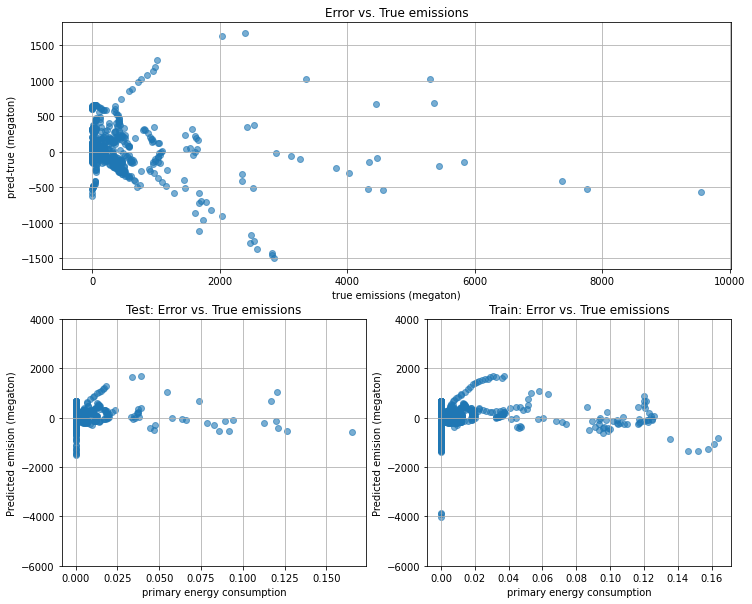

In [73]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_rgns_norm_test,y=y_rgns_norm_pred_test-y_rgns_norm_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_rgns_norm_test['primary_energy_consumption_10Gwh'],y=y_rgns_norm_pred_test-y_rgns_norm_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_rgns_norm_train['primary_energy_consumption_10Gwh'],y=y_rgns_norm_pred_train-y_rgns_norm_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')


### 3.3.7 scikit-learn regression Lasso

In [74]:
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [75]:
# initiation
lasso_rgns = Lasso(alpha=0.1, fit_intercept=True, normalize=True, selection='cyclic', max_iter=10000, tol=0.0001, warm_start=False)

In [76]:
# train the model
lasso_rgns.fit(x_rgns_train,y_rgns_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [77]:
# predict
y_rgns_lasso_pred_train = lasso_rgns.predict(x_rgns_train)
 # print(y_afr_pred_train)
y_rgns_lasso_pred_test = lasso_rgns.predict(x_rgns_test)
 # print(y_afr_pred_test)

In [78]:
# calculate r2
lasso_rgns_r2_train = r2_score(y_rgns_train,y_rgns_lasso_pred_train)
print(ml_rgns_r2_train)
lasso_rgns_r2_test = r2_score(y_rgns_test,y_rgns_lasso_pred_test)
print(lasso_rgns_r2_test)

0.8546955154332705
0.8925155353134694


In [79]:
# add results to hypertable
results = {}
results['Country/Region'] = '6 Regions'
results['r2_train'] = lasso_rgns_r2_train
results['rmse_train'] = rmse(y_rgns_train,y_rgns_lasso_pred_train)
results['r2_test'] = lasso_rgns_r2_test
results['rmse_test'] = rmse(y_rgns_test,y_rgns_lasso_pred_test)
results['coef'] = lasso_rgns.coef_
results['incpt'] = lasso_rgns.intercept_                       
results['model'] = lasso_rgns.__class__.__name__
results['features'] = ['primary_energy_consumption','gdp','population','Value_argi','Value_beef']
results['_isnan'] = True
results['_square'] = False
results['_cubic'] = False
results['_threshold'] = True
results['description'] = 'Lasso & Dummies of USA, China, India, Russia, Europe, Africa'

hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('rmse_test')

,Country/Region,r2_train,rmse_train,r2_test,rmse_test,coef,incpt,model,features,_isnan,_square,_cubic,_threshold,description
3,Africa,0.794053,21.003896,0.580662,30.291292,"[0.1732299836507017, 3.568727125978023e-11, -9...",-4.601639,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
2,Europe,0.839988,64.874311,0.818085,66.570810,"[0.14595503831954054, -3.8284013587791104e-11,...",-1.482994,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
6,6 Regions,0.848635,253.310302,0.892516,164.391454,"[0.11258044144410691, 1.4117528652993696e-10, ...",-52.359327,Lasso,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Lasso & Dummies of USA, China, India, Russia, ..."
5,6 Regions,0.854696,248.187434,0.883595,171.076869,"[25893.662497465073, 11083.855442688671, 31210...",-257.285604,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Normalize & Dummies of USA, China, India, Russ..."
4,6 Regions,0.854696,248.187434,0.883595,171.076869,"[0.12095114157735147, 1.0898233159802549e-10, ...",-257.285604,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,"Dummies of USA, China, India, Russia, Europe, ..."
0,USA,0.987603,228.758732,0.989255,214.712913,"[0.1648775319616935, -1.2227772017644723e-10, ...",-2076.839054,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)
1,China,0.965934,557.302692,0.875232,884.073421,"[0.025720716814137783, 2.7440586493508506e-10,...",-668.197661,LinearRegression,"[primary_energy_consumption, gdp, population, ...",True,False,False,True,Multivariate(fea=5)


In [82]:
coefs_rgns = hypertable[4]['coef'].round(3)
coefs_rgns = pd.Series(dict(zip(list(feature_names), list(coefs_rgns)))).sort_values()
coefs_rgns

dm_India                           -937.440
dm_China                           -618.809
argi_isnan                          -70.573
gdp_isnan                           -19.466
Value_agri_1000hectare               -0.001
gdp                                   0.000
population                            0.000
Value_beef_tonnes                     0.000
emissions_gt_110k                    -0.000
emissions_gt_70k                      0.000
primary_energy_consumption_10Gwh      0.121
population_isnan                     10.397
energy_isnan                         75.856
beef_isnan                           80.910
dm_Africa                           190.014
dm_Europe                           193.238
dm_Russia                           394.746
dm_USA                              778.250
dtype: float64

In [83]:
coefs_rgns = hypertable[6]['coef'].round(3)
coefs_rgns = pd.Series(dict(zip(list(feature_names), list(coefs_rgns)))).sort_values()
coefs_rgns

dm_India                           -648.324
dm_China                           -254.104
gdp                                   0.000
population                            0.000
Value_agri_1000hectare               -0.000
Value_beef_tonnes                     0.000
gdp_isnan                            -0.000
population_isnan                     -0.000
dm_Europe                             0.000
emissions_gt_70k                      0.000
emissions_gt_110k                     0.000
dm_Africa                            -0.000
primary_energy_consumption_10Gwh      0.113
beef_isnan                            3.075
argi_isnan                           19.982
energy_isnan                         43.659
dm_Russia                           219.942
dm_USA                              608.174
dtype: float64

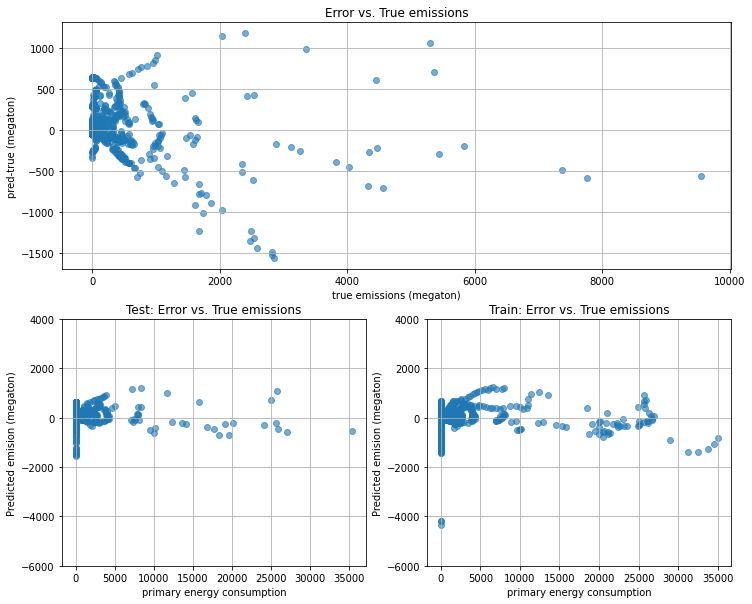

In [920]:
#plot the results
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.scatter(x=y_rgns_test,y=y_rgns_lasso_pred_test-y_rgns_test,alpha=0.6)
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Error vs. True emissions')
plt.grid('on')

plt.subplot(223)
plt.scatter(x=x_rgns_test['primary_energy_consumption_10Gwh'],y=y_rgns_lasso_pred_test-y_rgns_test,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')

plt.subplot(224)
plt.scatter(x=x_rgns_train['primary_energy_consumption_10Gwh'],y=y_rgns_lasso_pred_train-y_rgns_train,alpha=0.6)
plt.xlabel('primary energy consumption')
plt.ylabel('Predicted emision (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-6000,4000])
plt.grid('on')


## 2.4 Save the data 

In [921]:
# save the data to a new csv file
datapath = '../data'
save_file(co2_data_df, 'co2_data_updated_v2.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data\co2_data_updated_v2.csv"


In [922]:
# !!! (residue plot => feature engi.)
# !!! any insight i can gain from this porject, talk about coeff. of my model.